In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything
from scipy.io import loadmat
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

c:\Users\mohammed\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
from utilities3 import *

In [68]:
import torch
import torch.nn as nn
import numpy as np

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x, y), (in_channel, out_channel, x, y) -> (batch, out_channel, x, y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coefficients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=(-2, -1))

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9  # pad the domain if input is non-periodic

        self.fc0 = nn.Linear(4, self.width)  # input channel is 3: (u0, x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x = self.conv0(x) + self.w0(x)
        x = torch.relu(x)
        x = self.conv1(x) + self.w1(x)
        x = torch.relu(x)
        x = self.conv2(x) + self.w2(x)
        x = torch.relu(x)
        x = self.conv3(x) + self.w3(x)

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


In [109]:
import torch as tf
import numpy as np
import time





def ui(x, y , model):
    return model(torch.cat((x.unsqueeze(0).unsqueeze(-1), y.unsqueeze(0).unsqueeze(-1)), dim=-1))


def f(x, y ,model):
    x.requires_grad_(True)
    y.requires_grad_(True)
    u = ui(x, y ,model)
    u = u[0,:,:,0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    x.requires_grad_(True)
    y.requires_grad_(True)
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True,retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True,retain_graph=True)[0]
    print(u_xx)
    
    
    return u_xx + u_yy 

def f2(x, y ,model):
    
    f_pred = f(x, y ,model)
    r = (f_pred - tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) -tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2) )
    return torch.abs(r)
def adaptive_collocation_points(x, y, model, k=1.0):
   
    residuals = f2(x, y, model)
    
    p = residuals**k / torch.sum(residuals**k)
    indices = torch.multinomial(p.flatten(), num_samples=p.numel(), replacement=True)
    x_new = x.flatten()[indices].unsqueeze(1)
    y_new = y.flatten()[indices].unsqueeze(1)

    #x_new += (torch.rand_like(x_new) - 0.5) * 0.05
    #y_new += (torch.rand_like(y_new) - 0.5) * 0.05
    return x_new, y_new
#initial and boundary conditions losses
def loss_boundary_1(x , model):
    u_boundary =  np.exp(-10*(x**2+1))

    return tf.mean((ui(x , -torch.ones_like(x),model) - u_boundary)**2)
def loss_boundary_2(x,model):

    
    
    u_pred = ui(x, torch.ones_like(x),model)
    u_boundary =  np.exp(-10*(x**2+1))
    u_boundary = u_boundary.unsqueeze(0).unsqueeze(-1)
    print(u_pred.shape,u_boundary.shape)

    return tf.mean((u_pred - u_boundary)**2)

def loss_boundary_3(y,model):
    u_boundary =  np.exp(-10*(y**2+1))
  
    return tf.mean((ui( torch.ones_like(y),y,model) - u_boundary)**2)

def loss_boundary_4(y ,model):
    u_boundary = np.exp(-10*(y**2+1))
  
    return tf.mean((ui( -torch.ones_like(y),y,model) - u_boundary)**2)
def check_for_interrupt():
    try:
        time.sleep(0)
    except KeyboardInterrupt:
        print("Interrupted!")
        raise KeyboardInterrupt

# pde loss
def loss_fn(x, y ,model):
    

    
    f_pred = f(x, y ,model)
   
    return torch.mean((f_pred - tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) -tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2) )**2) 


def loss_fn2(x, y ,pinn):

    
    f_pred = f(x, y ,pinn) 
 
    return torch.mean((f_pred - tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) -tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2) )**2)

def create_grid(num_points):
    x = np.linspace(-1, 1, num_points)
    y = np.linspace(-1, 1, num_points)
    x_grid, y_grid = np.meshgrid(x, y)
    x_grid = x_grid.flatten()
    y_grid = y_grid.flatten()
    return x_grid, y_grid

# Step 2: Randomly select points from the grid
def select_random_points(x_grid, y_grid, num_samples):
    indices = np.random.choice(len(x_grid), num_samples, replace=False)
    selected_x = x_grid[indices]
    selected_y = y_grid[indices]
    return selected_x, selected_y




In [127]:

def train_model(model, optimizer, epochs, x, y, u_exact):
    model.train()
    

    for epoch in range(epochs):
        optimizer.zero_grad()
        
        u_exact = u_exact.view(1, 100, 100)
        
        output = ui(x,torch.ones_like(x),model)
        
        loss = torch.mean((output-u_exact.unsqueeze(-1))**2)
        loss.backward()
        
        optimizer.step()

        if epoch % 100 == 0:
            print(output.shape)
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Sample data (replace with your actual data)
x = torch.linspace(-1, 1, 100)
y = torch.linspace(-1, 1, 100)
x, y = torch.meshgrid(x, y)
#x, y = x.flatten(), y.flatten()

u_exact = torch.exp(-10 * (x**2 + 1**2)) 
# Example exact solution


# Initialize model, optimizer and train
modes1, modes2, width = 1, 1, 20
model = FNO2d(modes1, modes2, width)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, optimizer, epochs=500, x=x, y=y, u_exact=u_exact)


torch.Size([1, 100, 100, 1])
Epoch 0, Loss: 4.1524836547068844e-07
torch.Size([1, 100, 100, 1])
Epoch 100, Loss: 2.095637219312607e-09
torch.Size([1, 100, 100, 1])
Epoch 200, Loss: 4.069782844062786e-10
torch.Size([1, 100, 100, 1])
Epoch 300, Loss: 2.2306508029590333e-10
torch.Size([1, 100, 100, 1])
Epoch 400, Loss: 1.6008748493501201e-10
torch.Size([1, 100, 100, 1])
Epoch 500, Loss: 1.2940008786710422e-10
torch.Size([1, 100, 100, 1])
Epoch 600, Loss: 1.1003851302371359e-10
torch.Size([1, 100, 100, 1])
Epoch 700, Loss: 9.596397981814775e-11
torch.Size([1, 100, 100, 1])
Epoch 800, Loss: 8.550862101719403e-11
torch.Size([1, 100, 100, 1])
Epoch 900, Loss: 7.748900132664716e-11


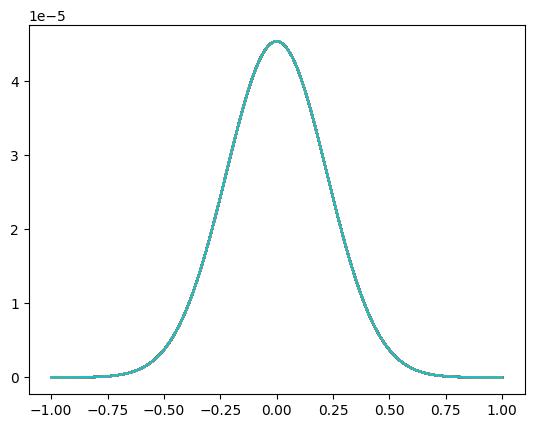

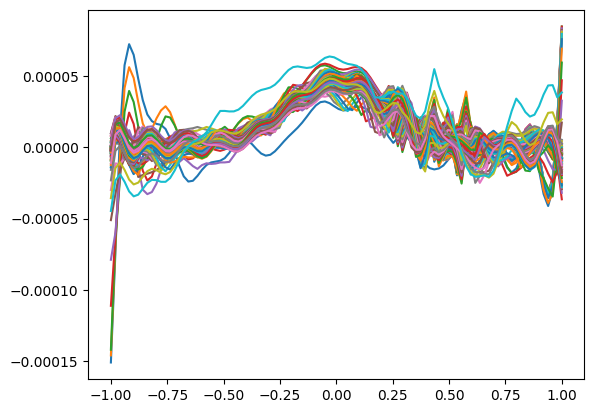

In [128]:
x = torch.linspace(-1, 1, 100)
y = torch.linspace(-1, 1, 100) 
x, y = torch.meshgrid(x, y)
u_pred = ui(x, torch.ones_like(x), model)
u_pred = u_pred[0,:,:,0]

u_boundary = torch.exp(-10*(x**2+1))

plt.plot(x , u_boundary )
plt.show()
plt.plot(x ,u_pred.detach().numpy())

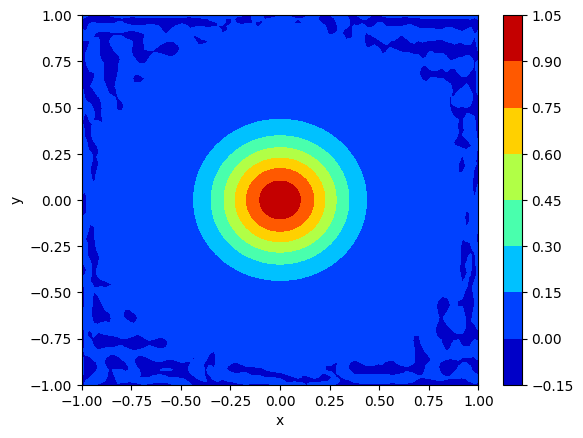

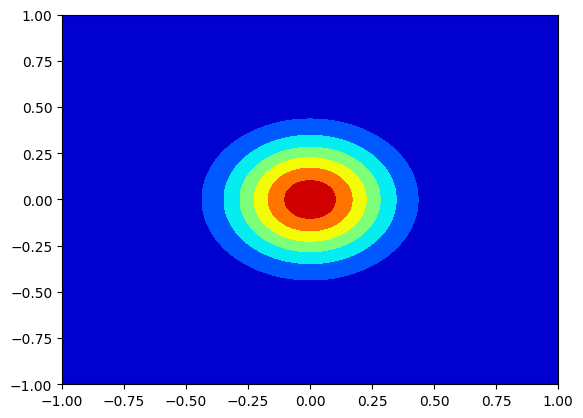

In [122]:
x = torch.linspace(-1, 1, 100)
y = torch.linspace(-1, 1, 100)
x, y = torch.meshgrid(x, y)
u_exact = torch.exp(-10 * (x**2 + y**2))
u_pred = model(torch.cat((x.unsqueeze(0).unsqueeze(-1), y.unsqueeze(0).unsqueeze(-1)), dim=-1))
plt.contourf(x,y,u_pred[0,:,:,0].detach().numpy(),cmap='jet')
plt.colorbar()

plt.xlabel('x')
plt.ylabel('y')
plt.show()
plt.contourf(x,y,u_exact,cmap='jet')
plt.show()

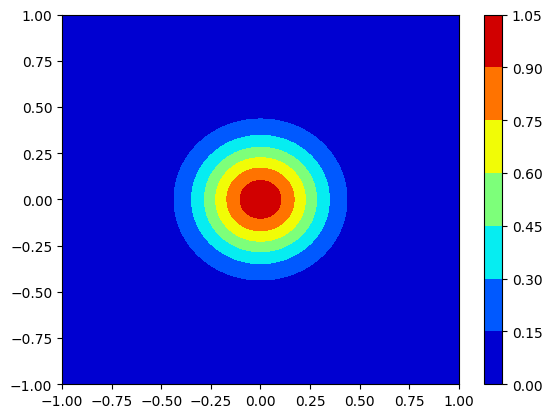

In [48]:
import numpy as np
import matplotlib.pyplot as plt

x = torch.linspace(-1, 1, 100)
y = torch.linspace(-1, 1, 100)
x, y = torch.meshgrid(x, y)
u_ex = torch.exp(-10 * (x**2 + y**2))

plt.contourf(x, y, u_ex , cmap='jet')
plt.colorbar()
plt.show()